In [1]:
import os
import warnings
import tqdm
import pandas as pd
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [2]:
%load_ext autoreload
%autoreload 2
import socceraction.atomic.spadl as atomicspadl
import socceraction.atomic.vaep.formula as vaepformula

## Select data

In [3]:
# Configure file and folder names
datafolder = "../data-fifa"
spadl_h5 = os.path.join(datafolder, "atomic-spadl-statsbomb.h5")
predictions_h5 = os.path.join(datafolder, "atomic-predictions-one-action.h5")

In [4]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    players = spadlstore["players"]
    teams = spadlstore["teams"]
print("nb of games:", len(games))

nb of games: 64


## Compute VAEP values

In [5]:
A = []
for game in tqdm.tqdm(list(games.itertuples()), desc="Loading actions"):
    actions = pd.read_hdf(spadl_h5, f"atomic_actions/game_{game.game_id}")
    actions = (
        atomicspadl.add_names(actions)
        .merge(players, how="left")
        .merge(teams, how="left",)
        .sort_values(["game_id", "period_id", "action_id"])
        .reset_index(drop=True)
    )
    preds = pd.read_hdf(predictions_h5, f"game_{game.game_id}")
    values = vaepformula.value(actions, preds.scores, preds.concedes)
    A.append(pd.concat([actions, preds, values], axis=1))
A = pd.concat(A).sort_values(["game_id", "period_id", "time_seconds"]).reset_index(drop=True)
A.columns

Loading actions: 100%|██████████| 64/64 [00:05<00:00, 11.68it/s]


Index(['game_id', 'original_event_id', 'action_id', 'period_id',
       'time_seconds', 'team_id', 'player_id', 'x', 'y', 'dx', 'dy', 'type_id',
       'bodypart_id', 'type_name', 'bodypart_name', 'player_name', 'nickname',
       'team_name', 'scores', 'concedes', 'offensive_value', 'defensive_value',
       'vaep_value'],
      dtype='object')

In [6]:
# Use this if you want to assign credit for the receival back to the initial passer
# A["player_id"] = A.player_id.mask(A.type_name == "receival", A.player_id.shift(1))

## Analyse VAEP ratings
### Most valuable players

In [7]:
A["count"] = 1

# Compute each player's number of actions and total VAEP values
playersR = (
    A[["player_id", "vaep_value", "offensive_value", "defensive_value", "count"]]
    .groupby(["player_id"])
    .sum()
    .reset_index()
)
# Add player names
playersR = playersR.merge(players[["player_id", "nickname", "player_name"]], how="left")
playersR["player_name"] = playersR[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
# Show results
playersR = playersR[["player_id", "player_name", "vaep_value", "offensive_value", "defensive_value", "count"]]
playersR.sort_values("vaep_value", ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count
6,3009.0,Kylian Mbappé,5.169373,4.928038,0.241335,721
92,3621.0,Eden Hazard,4.907491,4.800539,0.106952,1035
172,5207.0,Cristiano Ronaldo,4.690831,4.302646,0.388184,463
44,3289.0,Romelu Lukaku,4.690621,4.607722,0.082900,399
122,4320.0,Neymar,4.648622,4.639754,0.008868,1118
265,5487.0,Antoine Griezmann,4.079341,3.810721,0.268620,811
250,5472.0,Mario Mandžukić,3.998799,3.686802,0.311998,548
252,5474.0,Ivan Perišić,3.920457,4.277172,-0.356715,710
152,5186.0,Denis Cheryshev,3.880123,4.418187,-0.538064,331
248,5470.0,Ivan Rakitić,3.815689,3.297262,0.518426,1295


In [8]:
# Normalize for minutes played
pg = pd.read_hdf(spadl_h5, "player_games")
pg = pg[pg.game_id.isin(games.game_id)]
mp = pg[["player_id", "minutes_played"]].groupby("player_id").sum().reset_index()

stats = playersR.merge(mp)
stats = stats[stats.minutes_played > 180] # at least two full games played
stats["vaep_rating"] = stats.vaep_value * 90 / stats.minutes_played
stats["offensive_rating"] = stats.offensive_value * 90 / stats.minutes_played
stats["defensive_rating"] = stats.defensive_value * 90 / stats.minutes_played
stats.sort_values("vaep_rating", ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
117,4269.0,Aleksandar Mitrović,3.409460,3.225634,0.183826,279,271,1.132293,1.071244,0.061049
152,5186.0,Denis Cheryshev,3.880123,4.418187,-0.538064,331,312,1.119266,1.274477,-0.155211
34,3237.0,Sergio Agüero,2.384831,2.342122,0.042710,210,193,1.112097,1.092181,0.019916
172,5207.0,Cristiano Ronaldo,4.690831,4.302646,0.388184,463,381,1.108070,1.016373,0.091697
75,3531.0,Mohamed Salah,2.179247,2.130537,0.048710,181,189,1.037736,1.014541,0.023195
164,5198.0,Diego Costa,3.563334,3.439192,0.124142,271,315,1.018095,0.982626,0.035469
251,5473.0,Ahmed Musa,2.413977,2.084013,0.329965,244,220,0.987536,0.852551,0.134985
16,3083.0,Son Heung-Min,3.022844,2.937081,0.085763,345,288,0.944639,0.917838,0.026801
29,3196.0,Wahbi Khazri,2.628477,2.361541,0.266936,286,264,0.896072,0.805071,0.091001
161,5195.0,Artem Dzyuba,3.372054,3.096581,0.275473,426,339,0.895236,0.822101,0.073135


### (optional) inspect Belgium's top 10 most valuable non-shot actions

2018-06-23 14:00:00 Belgium 5-2 Tunisia 89' receival 3457.0


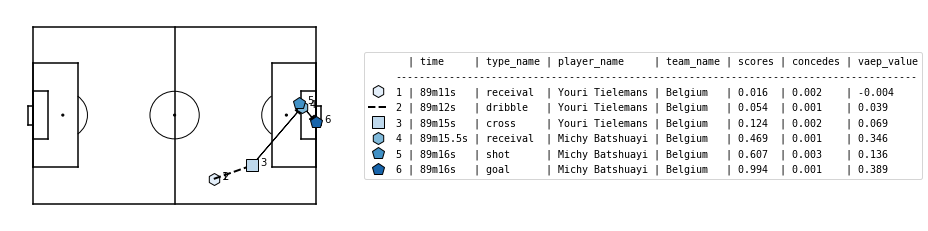

2018-07-14 16:00:00 Belgium 2-0 England 3' receival 3176.0


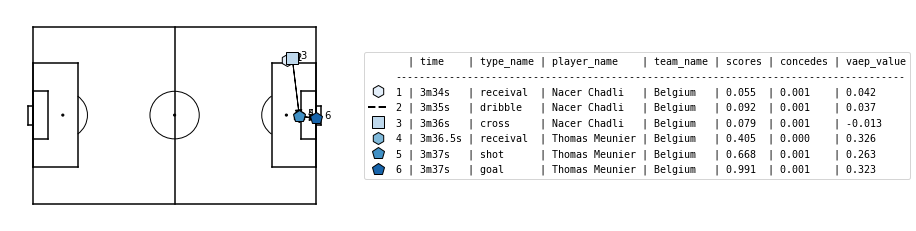

2018-06-28 20:00:00 England 0-1 Belgium 9' dribble 3457.0


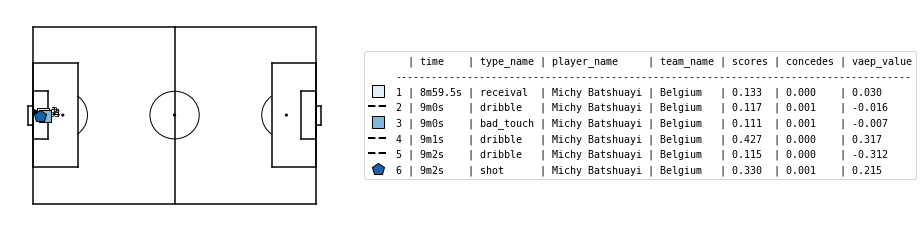

2018-06-23 14:00:00 Belgium 5-2 Tunisia 91' take_on 3457.0


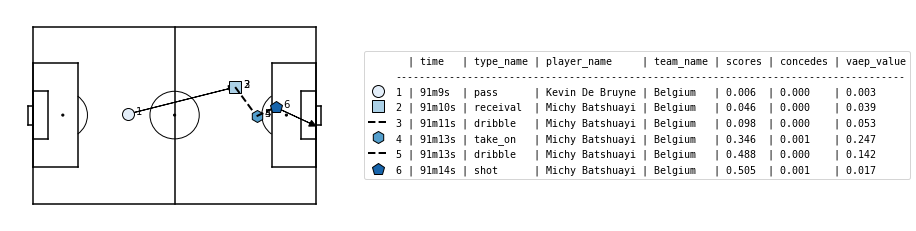

2018-06-18 17:00:00 Belgium 3-0 Panama 74' dribble 3289.0


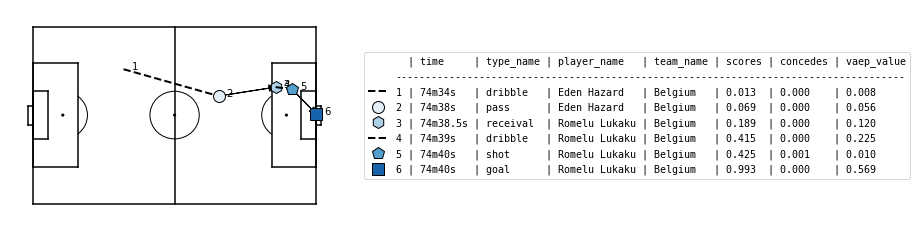

2018-06-28 20:00:00 England 0-1 Belgium 90' dribble 3296.0


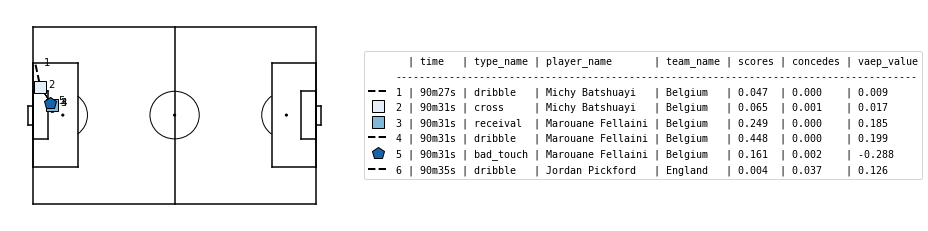

2018-07-02 20:00:00 Belgium 3-2 Japan 48' dribble 3621.0


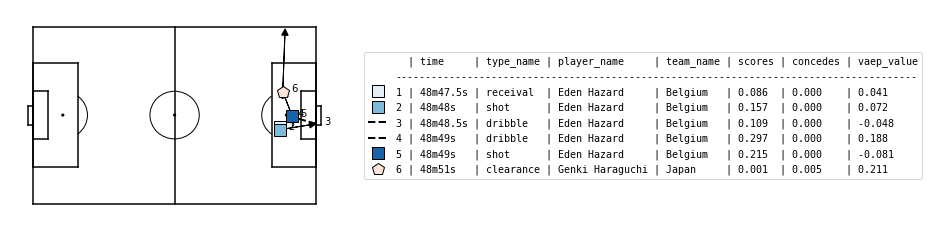

2018-06-28 20:00:00 England 0-1 Belgium 90' receival 3296.0


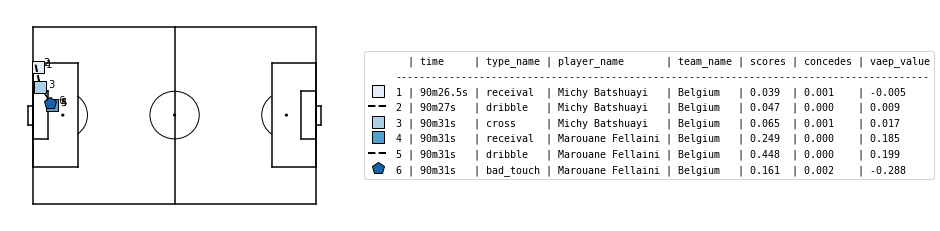

2018-06-18 17:00:00 Belgium 3-0 Panama 89' corner 3621.0


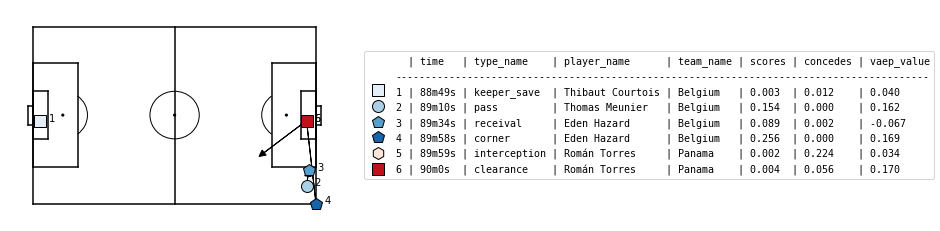

2018-06-23 14:00:00 Belgium 5-2 Tunisia 75' receival 3457.0


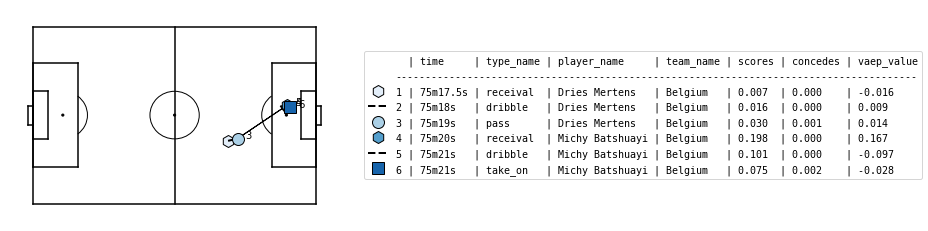

In [9]:
import matplotsoccer

sorted_A = A.sort_values("offensive_value", ascending=False)
sorted_A = sorted_A[sorted_A.team_name == "Belgium"] # view only actions from Belgium
sorted_A = sorted_A[~sorted_A.type_name.isin(["goal", "shot", "shot_penalty"])] #eliminate shots

def get_time(period_id,time_seconds):
    m = int((period_id-1) * 45 + time_seconds // 60)
    s = time_seconds % 60
    if s == int(s):
        s = int(s)
    return f"{m}m{s}s"

for j in range(0,10):
    row = list(sorted_A[j:j+1].itertuples())[0]
    i = row.Index
    a = A[i - 3 : i + 3].copy()
    
    a["player_name"] = a[["nickname" ,"player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
    
    g = list(games[games.game_id == a.game_id.values[0]].itertuples())[0]
    game_info = f"{g.game_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name}"
    minute = int((row.period_id - 1) * 45 + row.time_seconds // 60)
    print(f"{game_info} {minute}' {row.type_name} {row.player_id}")

    a["scores"] = a.scores.apply(lambda x : "%.3f" % x )
    a["concedes"] = a.concedes.apply(lambda x : "%.3f" % x )
    a["vaep_value"] = a.vaep_value.apply(lambda x : "%.3f" % x )
    a["time"] = a[["period_id","time_seconds"]].apply(lambda x: get_time(*x),axis=1)
    cols = ["time", "type_name", "player_name", "team_name", "scores", "concedes", "vaep_value"]
    a["end_x"] = a.x + a.dx
    a["end_y"] = a.y + a.dy
    matplotsoccer.actions(a[["x", "y", "end_x", "end_y"]],
                a.type_name,
                team=a.team_name,
                label=a[cols],
                labeltitle = cols,
                zoom=False)